In [81]:
#Grab some relevant part of util.py in qtrkx-gnn-tracking

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import namedtuple
#internal
import os, sys, glob, yaml, datetime, argparse
import csv
import tensorflow as tf
import matplotlib.pyplot as plt
Graph = namedtuple('Graph', ['X', 'Ri', 'Ro', 'y'])

class GraphDataset():
    def __init__(self, input_dir, n_samples=None):
        input_dir = os.path.expandvars(input_dir)
        filenames = [os.path.join(input_dir, f) for f in os.listdir(input_dir)
                     if f.startswith('event') and f.endswith('.npz')]
        self.filenames = (
            filenames[:n_samples] if n_samples is not None else filenames)

    def __getitem__(self, index):
        return load_graph(self.filenames[index])

    def __len__(self):
        return len(self.filenames)
def get_dataset(input_dir,n_files):
    return GraphDataset(input_dir, n_files)
def load_graph(filename):
    """Reade a single graph NPZ"""
    with np.load(filename) as f:
        return sparse_to_graph(**dict(f.items()))
def sparse_to_graph(X, Ri_rows, Ri_cols, Ro_rows, Ro_cols, y, dtype=np.float32):
    n_nodes, n_edges = X.shape[0], Ri_rows.shape[0]
    Ri = np.zeros((n_nodes, n_edges), dtype=dtype)
    Ro = np.zeros((n_nodes, n_edges), dtype=dtype)
    Ri[Ri_rows, Ri_cols] = 1
    Ro[Ro_rows, Ro_cols] = 1
    return Graph(X, Ri, Ro, y)

#New part starts from here
def graph_coloring(graph_name):
    graph_ex=load_graph(graph_name)
    #Load raw data
    X = graph_ex.X
    Ri=graph_ex.Ri
    Ro=graph_ex.Ro
    y=graph_ex.y
    #Need to change type for later use.
    y=y.astype(np.int32)
    Ri = Ri.astype(np.int32)
    Ro = Ro.astype(np.int32)
    # Get the number of nodes and edges
    NV, NE = Ri.shape
    # Initialize the coloring vector
    coloring = np.zeros(NV, dtype=int)
    # Create a dictionary to store the neighbors of each node
    neighbors = {i: [] for i in range(NV)}
    print("Start getting neighborhood information")
    for k in range(NE):
        if k%2000==0: 
            print("Performing ",k,"-th iteration...")
        if y[k] == 1:
            for j in range(NV):
                if Ro[j, k] == 1:
                    for i in range(NV):
                        if Ri[i, k] == 1 and i != j:
                            neighbors[j].append(i)
    print("Start greedy coloring.")
    # Greedy coloring
    for node in range(NV):
        used_colors = set(coloring[n] for n in neighbors[node])
        # Find the smallest unused color
        color = 0
        while color in used_colors:
            color += 1
        coloring[node] = color
    return X, y, Ri, Ro, coloring
def color_df(original_X,color):
    X_color = pd.DataFrame(original_X,columns=['x','y','z'])
    X_color['color'] = coloring
    return X_color
def color_df_red(original_X,color):
    X_color=color_df(original_X,color)
    X_color['r'] = np.sqrt(X_color['x']**2 + X_color['y']**2)
    X_color_red=X_color[(X_color['z']<0.1)&(X_color['z']>-0.1)
                   &(X_color['y']>0)&(X_color['r']<0.2)]
    return X_color_red
def plot3d(df,st):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    # Replace 'x', 'y', 'z', and 'label' with the actual column names in your DataFrame
    x = df['x']
    y = df['y']
    z = df['z']
    label = df[st]
    scatter = ax.scatter(x, y, z, c=label, cmap='viridis')
    # Add a colorbar to show the mapping of labels to colors
    colorbar = plt.colorbar(scatter)
    colorbar.set_label('Label')
    # Set labels for the axes
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.set_zlabel('Z-axis')
    # Show the plot
    plt.show()
def plot2d(df,st):
    # Replace 'x', 'y', and 'label' with the actual column names in your DataFrame
    x = df['x']
    y = df['y']
    labels = df[st]
    # Create a scatter plot with colors based on the 'label' column
    plt.scatter(x, y, c=labels, cmap='viridis')
    # Add a colorbar to show the mapping of labels to colors
    colorbar = plt.colorbar()
    colorbar.set_label('Label')
    # Set labels for the axes
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    # Show the plot
    plt.show()

In [39]:
X, y, Ri, Ro, coloring = graph_coloring('event000001000_g000.npz')
print(coloring)

Start getting neighborhood information
Performing  0 -th iteration...
Performing  2000 -th iteration...
Performing  4000 -th iteration...
Performing  6000 -th iteration...
Performing  8000 -th iteration...
Performing  10000 -th iteration...
Start greedy coloring.
Performing  0 -th iteration...
Performing  1000 -th iteration...
Performing  2000 -th iteration...
Performing  3000 -th iteration...
Performing  4000 -th iteration...
Performing  5000 -th iteration...
Performing  6000 -th iteration...
[1 1 1 ... 1 1 0]


In [44]:
print("Coloring vector sum: ",coloring.sum(), ", y vector sum: ",y.sum())

Coloring vector sum:  5162 , y vector sum:  5162


In [92]:
X_color = color_df_red(X,coloring)
X_color.shape

(150, 5)

In [93]:
X_color[X_color['color']==0]

,x,y,z,color,r
3131,0.07165,0.058419,0.088896,0,0.092447


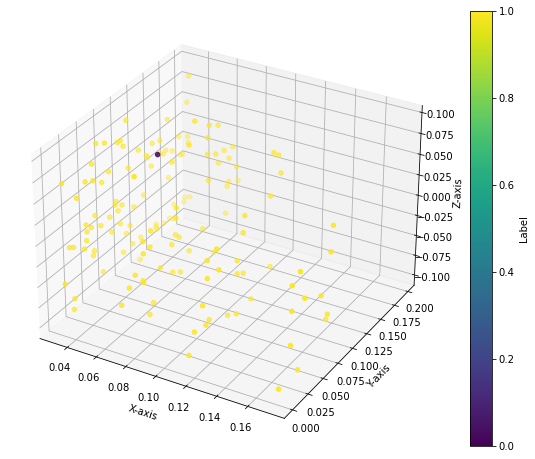

In [87]:
plot3d(X_color,'color')

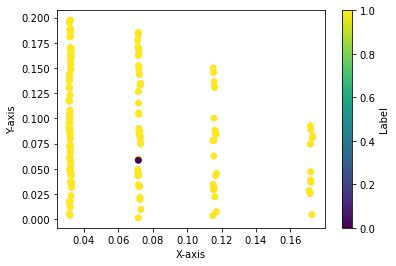

In [89]:
plot2d(X_color,'color')